# How has the COVID-19 pandemic affected air quality and single-use plastic waste in the U.S.?

<p>Statistical techniques that could help with EDA:
  
- causal inference (in particular, matching)
- hypothesis testing
- logistics regression (some sort of binary income - e.g. cancer/no cancer)
- ordinary least-squares linear regression
- chi squared test</p>

In [15]:
# Load packages
import os
import pandas as pd
import numpy as np

# Load regex package
import re

# Required for basic python plotting functionality
import matplotlib.pyplot as plt

# Advanced plotting functionality with seaborn
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
#from pingouin import pairwise_ttests #this is for performing the pairwise tests

# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline

# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates

# Required to display image inline
from IPython.display import Image

sns.set(style="whitegrid")  # can set style depending on how you'd like it to look

<p>The following datasets are taken from Federal Reserve Bank of St. Louis Plastic Manufacturing Dataset:
https://fred.stlouisfed.org/searchresults/?st=plastic&t=plastics%3Bmonthly%3Btrade&rt=trade&ob=sr

Note: U.S. recessions should probably be taken into account as a confounding factor.</p>

In [ ]:
# Dataset 'Producer Price Index by Commodity: Rubber and Plastic Products: Plastic Packaging Products'
# Index Dec 2006=100, Not Seasonally Adjusted
Plastic_packaging = pd.read_csv("WPU072A.csv")

# Dataset 'Producer Price Index by Industry: Material Recyclers: Recyclable Plastics'
# Index Jun 1996=100, Not Seasonally Adjusted
# Note: there is a gap in the dataset: data between around January 2004 and around June 2004 is missing
# Might need to impute?
Recyclers_recyclable_plastics = pd.read_csv("PCU42993042993042.csv")

# Dataset 'Producer Price Index by Commodity: Rubber and Plastic Products: Recyclable Plastics'
# Index Dec 2011=100, Not Seasonally Adjusted
Rubber_and_Plastic_recyclable_plastics = pd.read_csv("WPU072C.csv")

# Dataset 'Producer Price Index by Industry: Plastics Material and Resins Manufacturing'
# Index Dec 1980=100, Not Seasonally Adjusted
Plastic_and_resin = pd.read_csv('../PCU325211325211.csv')

# Dataset 'Producer Price Index by Industry: Plastics Packaging Film and Sheet Manufacturing: Coextruded Single-Web Film, for Flexible Packaging Uses'
# Index Jun 2007=100, Not Seasonally Adjusted
Plastic_film_and_sheet = pd.read_csv('../PCU32611232611212.csv')

# Dataset 'Producer Price Index by Commodity: Rubber and Plastic Products: Unlaminated Polyethylene Film and Sheet'
# Index Jun 1993=100, Not Seasonally Adjusted
# Data missing from June 2007 until July 2013 - impute?
Unlam_poly_film_and_sheet = pd.read_csv('../WPU072205011.csv')

# Dataset 'Producer Price Index by Commodity: Rubber and Plastic Products: Packaging Polyurethane Foam Products'
# Index Dec 2009=100, Not Seasonally Adjusted
# Note: data missing in interval May-June 2018 - need to impute?
Polyurethane_foam = pd.read_csv('../WPU072A01013.csv')

# Dataset 'Producer Price Index by Commodity: Rubber and Plastic Products: Unlaminated Vinyl and Vinyl Copolymer Film and Sheet'
# Index Dec 2011=100, Not Seasonally Adjusted
Vinyl_film_and_sheet = pd.read_csv('../WPU072205013.csv')

# Dataset 'Producer Price Index by Industry: Plastics Product Manufacturing'
# Index Jun 1993=100, Not Seasonally Adjusted
Plastic_manu = pd.read_csv('../PCU32613261.csv')

# Dataset 'Producer Price Index by Commodity: Rubber and Plastic Products: Plastic Products'
# Index 1982=100, Not Seasonally Adjusted
Plastic = pd.read_csv('../WPU072.csv')

# Dataset 'Producer Price Index by Industry: Plastics Bag and Pouch Manufacturing: Other Polyethylene Bags, Pouches, and Liners'
# Index Jun 2007=100, Not Seasonally Adjusted
# Note: delete first datapoint - it's temporally separated from all the rest
Plastic_bags = pd.read_csv('../PCU32611132611115.csv')

# Dataset 'Producer Price Index by Industry: Plastics Packaging Film and Sheet Manufacturing'
# Index Dec 2003=100, Not Seasonally Adjusted
Plastic_film_and_sheet_manu = pd.read_csv('../PCU326112326112.csv')

# Dataset 'Producer Price Index by Industry: Plastics Packaging Film and Sheet Manufacturing: Polypropylene/Polypropylene Multiweb Laminated Rolls and Sheets, for Flexible Packaging Uses'
# Index Jun 2007=100, Not Seasonally Adjusted
Polypropylene_packaging = pd.read_csv('../PCU32611232611231.csv')

# Dataset 'Producer Price Index by Industry: Plastics Bag and Pouch Manufacturing: Polyethylene Refuse Bags'
# Index Jun 2007=100, Not Seasonally Adjusted
# Note: delete first datapoint - it's temporally separated from all the rest
Polyethylene_refuse_bags = pd.read_csv('../PCU32611132611112.csv')

<p>The above datasets are about the producer price index, which is the change in price of the plastic goods. This doesn’t necessarily correlate with the amount of plastic produced (especially if you take the recession into account), therefore they are not appropriate for our purpose. However, the following dataset may be appropriate:</p>

In [2]:
# Dataset 'Industrial Production: Manufacturing: Non-Durable Goods: Plastics Material and Resin'
# Index 2012=100, Seasonally Adjusted
Plastic_and_resin_manu = pd.read_csv("IPN325211S.csv")

In [3]:
Plastic_and_resin_manu.shape

(583, 2)

In [4]:
Plastic_and_resin_manu.head()

,DATE,IPN325211S
0,1972-01-01,38.9872
1,1972-02-01,38.8303
2,1972-03-01,40.1707
3,1972-04-01,40.5691
4,1972-05-01,41.0615


<p>The following dataset is from the US Department of Transportation and contains data on docked bike ridership (downloaded from https://data.bts.gov/Research-and-Statistics/Docked-Bikeshare-Ridership-by-System-Year-Month-an/g3h6-334u)</p>

In [5]:
# Dataset on bikeshare ridership in several US cities
Bikeshare_ridership = pd.read_csv("Docked_Bikeshare_Ridership_by_System__Year__Month__and_Day.csv")
Bikeshare_ridership.shape

(5251, 8)

In [6]:
print(Bikeshare_ridership["sysname_alt"].unique())

['Boston Metro, MA (Blue Bikes)' 'New York, NY (CitiBike)'
 'Minneapolis, MN (Nice Ride Minnesota)' 'San Francisco, CA (Bay Wheels)'
 'Philadelphia, PA (Indego)' 'Chattanooga, TN (Bike Chattanooga)'
 'Washington, DC Metro (Capital Bikeshare)' 'CoGo (Columbus, OH)'
 'Chicago, IL (Divvy)' 'Los Angeles, CA (Metro Bike Share)'
 'Portland, OR (BikeTown)' 'Jersey City, NJ (CitiBike)']


In [ ]:
NY_Bikeshare_ridership = Bikeshare_ridership[
    Bikeshare_ridership["sysname_alt"] == "New York, NY (CitiBike)"
].copy()
NY_Bikeshare_ridership.head(20)

<p>Separate day, month, year into individual columns:</p>

In [ ]:
NY_Bikeshare_ridership["month"] = NY_Bikeshare_ridership["yr_mo_d"].apply(
    lambda y: int(str(y)[:2])
)
NY_Bikeshare_ridership["day"] = NY_Bikeshare_ridership["yr_mo_d"].apply(
    lambda y: int(str(y)[3:5])
)

In [7]:
Clean_Bikeshare_ridership = Bikeshare_ridership.copy()
Clean_Bikeshare_ridership["month"] = Bikeshare_ridership["yr_mo_d"].apply(
    lambda y: int(str(y)[:2])
)
Clean_Bikeshare_ridership["day"] = Bikeshare_ridership["yr_mo_d"].apply(
    lambda y: int(str(y)[3:5])
)

<p>Remove assigned_month column and yr_mo_d column which is not useful any more:</p>

In [ ]:
NY_Bikeshare_ridership = NY_Bikeshare_ridership.drop(["assigned_month", "yr_mo_d"], axis=1)

In [ ]:
Clean_Bikeshare_ridership = Clean_Bikeshare_ridership.drop(["assigned_month", "yr_mo_d"], axis=1)

In [ ]:
print(NY_Bikeshare_ridership["sysname"].unique())

In [8]:
print(Clean_Bikeshare_ridership["sysname"].unique())

['Blue Bikes (Boston, MA)' 'Citi Bike (New York, NY)'
 'Nice Ride Minnesota (Minneapolis, MN)' 'Bay Wheels (San Francisco, CA)'
 'Indego (Philadelphia, PA)' 'Bike Chattanooga (Chattanooga, TN)'
 'Capital Bikeshare (Washington, DC)' 'CoGo (Columbus, OH)'
 'Divvy (Chicago, IL)' 'Metro Bike Share (Los Angeles, CA)'
 'BikeTown (Portland, OR)' 'CitiBike (Jersey City, NJ)']


In [ ]:
NY_Bikeshare_ridership = NY_Bikeshare_ridership.drop("sysname", axis = 1)

In [ ]:
NY_Bikeshare_ridership = NY_Bikeshare_ridership.drop("sysid", axis = 1)

In [ ]:
NY_Bikeshare_ridership.head(20)

In [9]:
Clean_Bikeshare_ridership = Clean_Bikeshare_ridership.drop("sysid", axis=1)
Clean_Bikeshare_ridership.head(20)

,sysname,year,assigned_month,yr_mo_d,sum_min,num_trip,sysname_alt,month,day
0,"Blue Bikes (Boston, MA)",2019,1,01/02/2019 12:00:00 AM,32187,2623,"Boston Metro, MA (Blue Bikes)",1,2
1,"Blue Bikes (Boston, MA)",2019,1,01/03/2019 12:00:00 AM,36632,2993,"Boston Metro, MA (Blue Bikes)",1,3
2,"Blue Bikes (Boston, MA)",2019,1,01/04/2019 12:00:00 AM,43345,3379,"Boston Metro, MA (Blue Bikes)",1,4
3,"Blue Bikes (Boston, MA)",2019,1,01/05/2019 12:00:00 AM,9177,782,"Boston Metro, MA (Blue Bikes)",1,5
4,"Blue Bikes (Boston, MA)",2019,1,01/06/2019 12:00:00 AM,21476,1620,"Boston Metro, MA (Blue Bikes)",1,6
5,"Blue Bikes (Boston, MA)",2019,1,01/07/2019 12:00:00 AM,32297,2858,"Boston Metro, MA (Blue Bikes)",1,7
6,"Blue Bikes (Boston, MA)",2019,1,01/08/2019 12:00:00 AM,34698,2970,"Boston Metro, MA (Blue Bikes)",1,8
7,"Blue Bikes (Boston, MA)",2019,1,01/09/2019 12:00:00 AM,40676,3375,"Boston Metro, MA (Blue Bikes)",1,9
8,"Blue Bikes (Boston, MA)",2019,1,01/10/2019 12:00:00 AM,39484,3320,"Boston Metro, MA (Blue Bikes)",1,10
9,"Blue Bikes (Boston, MA)",2019,1,01/11/2019 12:00:00 AM,30072,2636,"Boston Metro, MA (Blue Bikes)",1,11


sum_min = Total trip time in minutes (divide by num_trip to get average trip time)

sum_trip = Total number of trips

In [10]:
print(Clean_Bikeshare_ridership["sysname_alt"].unique())

['Boston Metro, MA (Blue Bikes)' 'New York, NY (CitiBike)'
 'Minneapolis, MN (Nice Ride Minnesota)' 'San Francisco, CA (Bay Wheels)'
 'Philadelphia, PA (Indego)' 'Chattanooga, TN (Bike Chattanooga)'
 'Washington, DC Metro (Capital Bikeshare)' 'CoGo (Columbus, OH)'
 'Chicago, IL (Divvy)' 'Los Angeles, CA (Metro Bike Share)'
 'Portland, OR (BikeTown)' 'Jersey City, NJ (CitiBike)']


In [11]:
print(Clean_Bikeshare_ridership["sysname"].unique())

['Blue Bikes (Boston, MA)' 'Citi Bike (New York, NY)'
 'Nice Ride Minnesota (Minneapolis, MN)' 'Bay Wheels (San Francisco, CA)'
 'Indego (Philadelphia, PA)' 'Bike Chattanooga (Chattanooga, TN)'
 'Capital Bikeshare (Washington, DC)' 'CoGo (Columbus, OH)'
 'Divvy (Chicago, IL)' 'Metro Bike Share (Los Angeles, CA)'
 'BikeTown (Portland, OR)' 'CitiBike (Jersey City, NJ)']


In [12]:
list(Clean_Bikeshare_ridership.keys())

['sysname',
 'year',
 'assigned_month',
 'yr_mo_d',
 'sum_min',
 'num_trip',
 'sysname_alt',
 'month',
 'day']

In [13]:
Clean_Bikeshare_ridership = Clean_Bikeshare_ridership[['sysname', 'sysname_alt', 'sum_min', 'num_trip', 'day', 'month', 'year']]
Clean_Bikeshare_ridership.head(20)

,sysname,sysname_alt,sum_min,num_trip,day,month,year
0,"Blue Bikes (Boston, MA)","Boston Metro, MA (Blue Bikes)",32187,2623,2,1,2019
1,"Blue Bikes (Boston, MA)","Boston Metro, MA (Blue Bikes)",36632,2993,3,1,2019
2,"Blue Bikes (Boston, MA)","Boston Metro, MA (Blue Bikes)",43345,3379,4,1,2019
3,"Blue Bikes (Boston, MA)","Boston Metro, MA (Blue Bikes)",9177,782,5,1,2019
4,"Blue Bikes (Boston, MA)","Boston Metro, MA (Blue Bikes)",21476,1620,6,1,2019
5,"Blue Bikes (Boston, MA)","Boston Metro, MA (Blue Bikes)",32297,2858,7,1,2019
6,"Blue Bikes (Boston, MA)","Boston Metro, MA (Blue Bikes)",34698,2970,8,1,2019
7,"Blue Bikes (Boston, MA)","Boston Metro, MA (Blue Bikes)",40676,3375,9,1,2019
8,"Blue Bikes (Boston, MA)","Boston Metro, MA (Blue Bikes)",39484,3320,10,1,2019
9,"Blue Bikes (Boston, MA)","Boston Metro, MA (Blue Bikes)",30072,2636,11,1,2019


In [16]:
new_bike_company_names = [re.sub( "\s\(.*\)", "", bike_company) for bike_company in Clean_Bikeshare_ridership["sysname"]]
Clean_Bikeshare_ridership["sysname"] = new_bike_company_names
new_place_names = [re.sub( "\s\(.*\)", "", place_name) for place_name in Clean_Bikeshare_ridership["sysname_alt"]]
Clean_Bikeshare_ridership["sysname_alt"] = new_place_names

In [ ]:
Clean_Bikeshare_ridership.to_csv("clean_bikeshare_ridership.csv")

In [33]:
#padded_day = [[str(day).zfill(2)] for day in Clean_Bikeshare_ridership["day"]]
#monthdayyear = list(Clean_Bikeshare_ridership["month"].map(str) + "/" + padded_day + "/" + Clean_Bikeshare_ridership["year"].map(str))
#Clean_Bikeshare_ridership["Date"] = monthdayyear
#Clean_Bikeshare_ridership.head(20)

Clean_Bikeshare_ridership["Date"] = Bikeshare_ridership["yr_mo_d"].apply(
    lambda mdy: str(mdy)[:10]
)

Clean_Bikeshare_ridership.head(20)

,sysname,sysname_alt,sum_min,num_trip,day,month,year,Date
0,Blue Bikes,"Boston Metro, MA",32187,2623,2,1,2019,01/02/2019
1,Blue Bikes,"Boston Metro, MA",36632,2993,3,1,2019,01/03/2019
2,Blue Bikes,"Boston Metro, MA",43345,3379,4,1,2019,01/04/2019
3,Blue Bikes,"Boston Metro, MA",9177,782,5,1,2019,01/05/2019
4,Blue Bikes,"Boston Metro, MA",21476,1620,6,1,2019,01/06/2019
5,Blue Bikes,"Boston Metro, MA",32297,2858,7,1,2019,01/07/2019
6,Blue Bikes,"Boston Metro, MA",34698,2970,8,1,2019,01/08/2019
7,Blue Bikes,"Boston Metro, MA",40676,3375,9,1,2019,01/09/2019
8,Blue Bikes,"Boston Metro, MA",39484,3320,10,1,2019,01/10/2019
9,Blue Bikes,"Boston Metro, MA",30072,2636,11,1,2019,01/11/2019


In [46]:
Clean_Bikeshare_ridership_1Jan2020 = Clean_Bikeshare_ridership.copy()
Clean_Bikeshare_ridership_1Jan2020[ Clean_Bikeshare_ridership_1Jan2020.year != 2019 ]

,sysname,sysname_alt,sum_min,num_trip,day,month,year,Date
272,Blue Bikes,"Boston Metro, MA",23510,1521,1,1,2020,01/01/2020
273,Blue Bikes,"Boston Metro, MA",48645,3750,2,1,2020,01/02/2020
274,Blue Bikes,"Boston Metro, MA",54444,4318,3,1,2020,01/03/2020
275,Blue Bikes,"Boston Metro, MA",18002,1446,4,1,2020,01/04/2020
276,Blue Bikes,"Boston Metro, MA",24751,1914,5,1,2020,01/05/2020
277,Blue Bikes,"Boston Metro, MA",53757,4501,6,1,2020,01/06/2020
278,Blue Bikes,"Boston Metro, MA",60822,5066,7,1,2020,01/07/2020
279,Blue Bikes,"Boston Metro, MA",55030,4644,8,1,2020,01/08/2020
280,Blue Bikes,"Boston Metro, MA",47755,4076,9,1,2020,01/09/2020
281,Blue Bikes,"Boston Metro, MA",63251,5057,10,1,2020,01/10/2020


In [ ]:
# Monthly transportation statistics dataset
Transportation = pd.read_csv("Monthly_Transportation_Statistics.csv")

In [ ]:
Transportation.shape

In [ ]:
Transportation.head()

In [ ]:
# Dataset on transportation emissions by state, 1980-2017
Transportation_CO2_emissions = pd.read_csv("transportation_CO2_emissions.csv")

In [ ]:
Transportation_CO2_emissions.shape

In [ ]:
Transportation_CO2_emissions.head()

In [ ]:
# 
Total_CO2_emissions = pd.read_csv("total_CO2_emissions.csv")

In [ ]:
Total_CO2_emissions.shape

In [ ]:
Total_CO2_emissions.head()

<p>Dataset from the National Oceanic and Atmospheric Administration (https://www.esrl.noaa.gov/gmd/ccgg/trends/), showing monthly mean carbon dioxide measured at Mauna Loa Observatory, Hawaii:</p>

In [ ]:
Monthly_CO2_Hawaii = pd.read_csv("NOAACO2.csv")

In [ ]:
Monthly_CO2_Hawaii.shape

In [ ]:
Monthly_CO2_Hawaii.tail()

<p>Data are reported as a dry air mole fraction defined as the number of molecules of carbon dioxide divided by the number of all molecules in air, including CO2 itself, after water vapor has been removed. The mole fraction (micromol CO2 per mol air) is expressed as parts per million (ppm).
    
   Key: 99.99 missing data; -1 no data for #daily means in month</p>

In [ ]:
County_COVID_cases = pd.read_csv("county_covid_cases.csv")

In [ ]:
County_COVID_cases.shape

In [ ]:
County_COVID_cases.head()

In [ ]:
County_COVID_deaths = pd.read_csv("county_covid_deaths.csv")

In [ ]:
County_COVID_deaths.shape

In [ ]:
County_COVID_deaths.head()

<p>Dataset for PM2.5 air pollution in the core-based statistical area (CBSA) of New York, Newark and Jersey (NY, NJ and PA states).</p>

In [20]:
PM2p5_air_New_York = pd.read_csv("pm2p5_aqi_tracker_data.csv")

In [21]:
PM2p5_air_New_York.head(20)

,Date,PM2.5 AQI Value,Site Name,Site ID,Source,20-year High (2000-2019),20-year Low (2000-2019),5-year Average (2015-2019)
0,01/01/2020,36,Intermediate School 143,36-061-0115,AQS,119,45,53.6
1,01/02/2020,56,Intermediate School 143,36-061-0115,AQS,134,37,61.8
2,01/03/2020,68,Fort Lee Near Road,34-003-0010,AQS,102,31,59
3,01/04/2020,63,Fort Lee Near Road,34-003-0010,AQS,108,28,52.2
4,01/05/2020,37,CCNY,36-061-0135,AQS,113,33,50.2
5,01/06/2020,47,Intermediate School 143,36-061-0115,AQS,113,26,56.4
6,01/07/2020,72,RICHMOND POST OFFICE,36-085-0055,AQS,121,36,59.4
7,01/08/2020,47,Intermediate School 143,36-061-0115,AQS,118,47,65.8
8,01/09/2020,43,Intermediate School 143,36-061-0115,AQS,108,38,56.8
9,01/10/2020,50,Intermediate School 143,36-061-0115,AQS,141,35,52.4


In [35]:
# Select only the New York portion of the dataset
biking_duration = Clean_Bikeshare_ridership[Clean_Bikeshare_ridership["sysname_alt"] == "New York, NY"][["Date", "sum_min"]].reset_index(drop=True)

PM2p5_ppm_NYNJPA = PM2p5_air_New_York[["Date", "PM2.5 AQI Value"]].reset_index(drop=True)

# Merge into one dataframe for ease of plotting
merged_bike_PM2p5_NY = pd.merge(
    biking_duration,
    PM2p5_ppm_NYNJPA,
    how="left",
    on=["Date"],
#    suffixes=("_BIKEMINS", "_PM2P5"),
)

merged_bike_PM2p5_NY.tail()

,Date,sum_min,PM2.5 AQI Value
513,08/28/2020,1320642,46
514,08/29/2020,1305358,32
515,08/30/2020,1934632,39
516,08/31/2020,1290654,32
517,09/01/2020,9225,33


Text(0,0.5,'Air quality (PM2.5 ppm)')

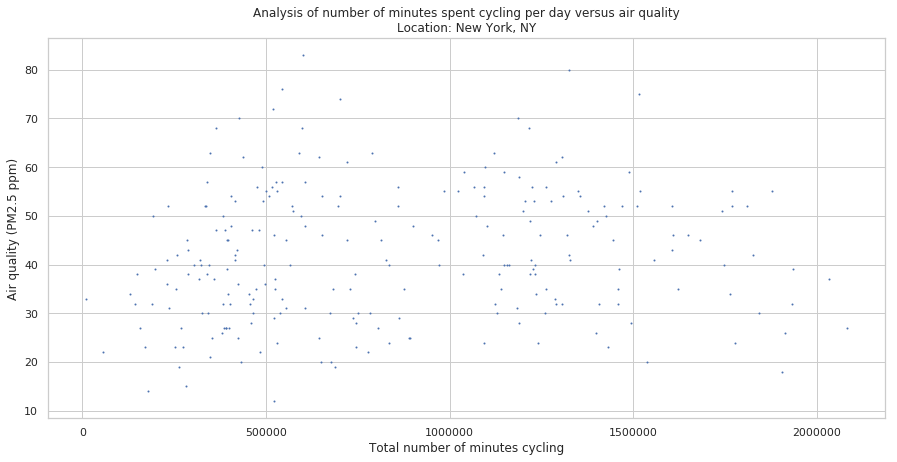

In [37]:
# Create basic scatter plot to view two-variable relationship
plt.figure(figsize=(15, 7))
plt.scatter(merged_bike_PM2p5_NY["sum_min"], merged_bike_PM2p5_NY["PM2.5 AQI Value"], s=1)
plt.title("Analysis of number of minutes spent cycling per day versus air quality\nLocation: New York, NY")
plt.xlabel("Total number of minutes cycling")
plt.ylabel("Air quality (PM2.5 ppm)")

<p>The bike data encompasses the date range 1 Feb 2019 - 1 Sep 2020. The air quality data encompasses 1 Jan 2020 - 1 Sep 2020. Note: TRIM AIR DATA!!!</p>

In [39]:
biking_duration.tail(20)

,Date,sum_min
498,08/13/2020,1037901
499,08/14/2020,1488718
500,08/15/2020,1877021
501,08/16/2020,683614
502,08/17/2020,1219290
503,08/18/2020,1462323
504,08/19/2020,1230319
505,08/20/2020,1459350
506,08/21/2020,1517758
507,08/22/2020,1741003


In [42]:
PM2p5_ppm_NYNJPA.tail(20)

,Date,PM2.5 AQI Value
346,12/12/2020,.
347,12/13/2020,.
348,12/14/2020,.
349,12/15/2020,.
350,12/16/2020,.
351,12/17/2020,.
352,12/18/2020,.
353,12/19/2020,.
354,12/20/2020,.
355,12/21/2020,.


In [54]:
cutoff = PM2p5_air_New_York.loc[PM2p5_air_New_York["Date"] == "09/01/2020"].index.tolist()
PM2p5_air_New_York_1Sep2020 = PM2p5_air_New_York.iloc[:cutoff[0]+1]
PM2p5_air_New_York_1Sep2020.tail()

,Date,PM2.5 AQI Value,Site Name,Site ID,Source,20-year High (2000-2019),20-year Low (2000-2019),5-year Average (2015-2019)
240,08/28/2020,46,Fort Lee Near Road,34-003-0010,AirNow,105,28,54
241,08/29/2020,32,Fort Lee Near Road,34-003-0010,AirNow,105,22,46.6
242,08/30/2020,39,Elizabeth Lab,34-039-0004,AirNow,85,32,49.8
243,08/31/2020,32,Newark Firehouse,34-013-0003,AirNow,98,25,49.6
244,09/01/2020,33,Newark Firehouse,34-013-0003,AirNow,99,29,48.2


In [55]:
# Select only the New York portion of the dataset
biking_duration_cropped = Clean_Bikeshare_ridership_1Jan2020[Clean_Bikeshare_ridership_1Jan2020["sysname_alt"] == "New York, NY"][["Date", "sum_min"]].reset_index(drop=True)

PM2p5_ppm_NYNJPA_cropped = PM2p5_air_New_York_1Sep2020[["Date", "PM2.5 AQI Value"]].reset_index(drop=True)

# Merge into one dataframe for ease of plotting
merged_bike_PM2p5_NY_cropped = pd.merge(
    biking_duration_cropped,
    PM2p5_ppm_NYNJPA_cropped,
    how="left",
    on=["Date"],
#    suffixes=("_BIKEMINS", "_PM2P5"),
)

merged_bike_PM2p5_NY_cropped.tail()

,Date,sum_min,PM2.5 AQI Value
513,08/28/2020,1320642,46
514,08/29/2020,1305358,32
515,08/30/2020,1934632,39
516,08/31/2020,1290654,32
517,09/01/2020,9225,33


Text(0,0.5,'Air quality (PM2.5 ppm)')

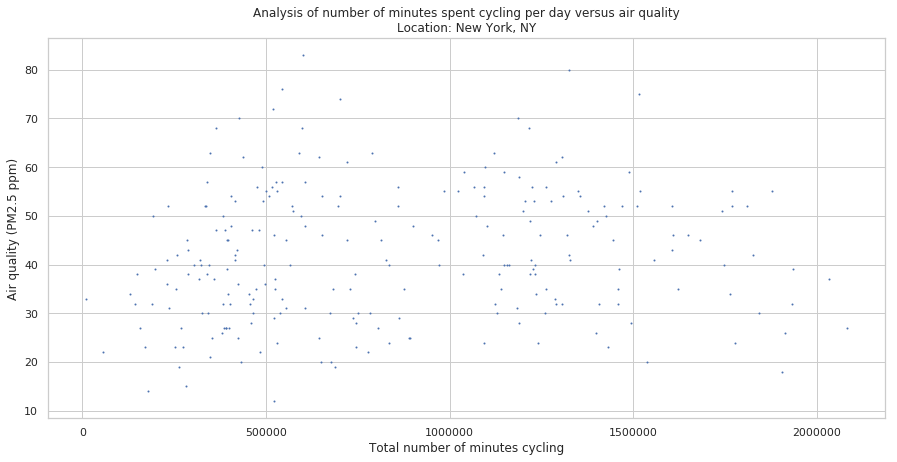

In [56]:
# Create basic scatter plot to view two-variable relationship
plt.figure(figsize=(15, 7))
plt.scatter(merged_bike_PM2p5_NY_cropped["sum_min"], merged_bike_PM2p5_NY_cropped["PM2.5 AQI Value"], s=1)
plt.title("Analysis of number of minutes spent cycling per day versus air quality\nLocation: New York, NY")
plt.xlabel("Total number of minutes cycling")
plt.ylabel("Air quality (PM2.5 ppm)")

<p>Dataset for PM2.5 air pollution in the core-based statistical area (CBSA) of Chicago, Naperville and Elgin (IL, IN and WI states).</p>

In [57]:
PM2p5_air_Chicago = pd.read_csv("pm2p5_aqi_tracker_data-Chicago.csv")
PM2p5_air_Chicago.head()

,Date,PM2.5 AQI Value,Site Name,Site ID,Source,20-year High (2000-2019),20-year Low (2000-2019),5-year Average (2015-2019)
0,01/01/2020,37,Hammond- 167th St,18-089-0036,AQS,151,21,45.2
1,01/02/2020,38,Kingery Near Road #1,17-031-0119,AQS,98,23,54
2,01/03/2020,56,Hammond- 167th St,18-089-0036,AQS,86,46,56.6
3,01/04/2020,48,East Chicago-Marina,18-089-0034,AQS,94,22,44.4
4,01/05/2020,31,Hammond- 167th St,18-089-0036,AQS,158,14,48.4


In [58]:
biking_duration_Chicago = Clean_Bikeshare_ridership[Clean_Bikeshare_ridership["sysname_alt"] == "Chicago, IL"][["Date", "sum_min"]].reset_index(drop = True)

PM2p5_ppm_ILINWI = PM2p5_air_Chicago[["Date", "PM2.5 AQI Value"]].reset_index(drop = True)

merged_bike_ppm_Chicago = pd.merge(
    biking_duration_Chicago,
    PM2p5_ppm_ILINWI,
    how = "left",
    on = ["Date"]
)

merged_bike_ppm_Chicago.tail()

,Date,sum_min,PM2.5 AQI Value
604,08/30/2020,593195,35
605,08/31/2020,309616,46
606,09/01/2020,5071,43
607,06/01/2020,0,35
608,06/02/2020,0,65


Text(0,0.5,'Air quality (PM2.5 ppm)')

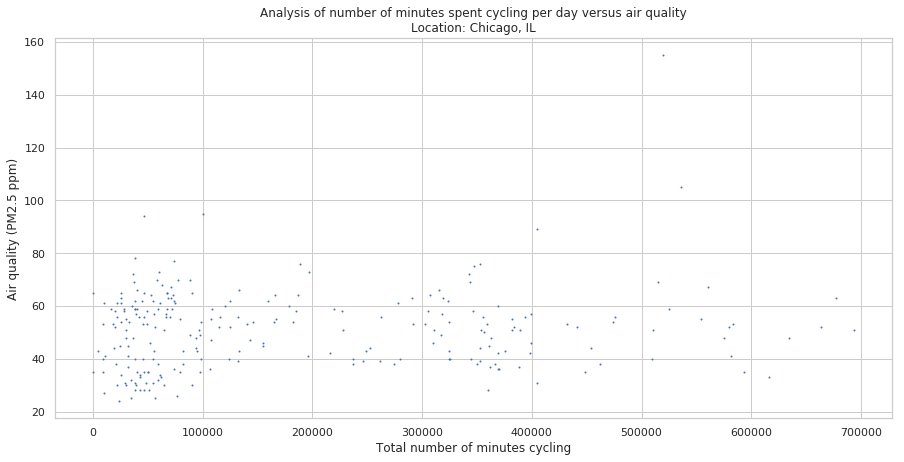

In [59]:
plt.figure(figsize = (15, 7))
plt.scatter(merged_bike_ppm_Chicago["sum_min"], merged_bike_ppm_Chicago["PM2.5 AQI Value"], s = 1)
plt.title("Analysis of number of minutes spent cycling per day versus air quality\nLocation: Chicago, IL")
plt.xlabel("Total number of minutes cycling")
plt.ylabel("Air quality (PM2.5 ppm)")